# import modules

In [3]:
import keras
from keras.utils import plot_model,to_categorical
from keras import Model,Input,regularizers
from keras.layers import Reshape,Flatten
import numpy as np
from sklearn.model_selection import train_test_split
import keras.backend as K
import keras.callbacks as kcallbacks
from sklearn.preprocessing import LabelEncoder
import string
from keras.optimizers import SGD
import warnings
import tensorflow as tf
# from lsuv_init import LSUVinit
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from keras.layers import Input, Dense, LSTM, merge ,Conv1D,Dropout,Bidirectional,Multiply,BatchNormalization,MaxPool1D
from keras.models import Model


from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *

import  pandas as pd
import  numpy as np
from keras.wrappers import scikit_learn

# Load Features

In [4]:

SINGLE_ATTENTION_VECTOR = False
def attention_3d_block(inputs, single_attention_vector=False):
    # 如果上一层是LSTM，需要return_sequences=True
    # inputs.shape = (batch_size, time_steps, input_dim)
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax', name='attention')(a)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1))(a)
        a = RepeatVector(input_dim)(a)

    a_probs = Permute((2, 1))(a)
    # 乘上了attention权重，但是并没有求和，好像影响不大
    # 如果分类任务，进行Flatten展开就可以了
    # element-wise
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


In [44]:
X_features=np.load('./feature/X_gabor.npy')
y=np.load('./feature/y_tone.npy')

In [45]:
X_features.shape

(4704, 35, 7)

In [46]:
means = np.mean(X_features, axis=0)
X_features -= means
stds = np.std(X_features, axis=0)
X_features /= stds

In [47]:
means = np.mean(X_features, axis=0)
means

array([[-8.56441241e-15, -2.35995558e-15,  3.39045213e-15,
        -1.55369859e-16, -3.79562217e-15,  4.51823480e-15,
        -5.59318512e-16],
       [-3.84277833e-15, -4.24495095e-15,  5.20204628e-16,
        -9.86078188e-17,  1.73177327e-15, -2.23420583e-15,
        -4.20263314e-16],
       [-6.34856869e-15,  6.33650823e-15,  1.63595045e-15,
        -2.05768886e-15, -4.65731950e-16,  2.24890968e-15,
         5.88354479e-16],
       [ 3.16956401e-15, -3.72302340e-15,  3.31419510e-15,
        -2.94893550e-15, -3.93170946e-15, -6.59100514e-16,
         3.53305348e-16],
       [-1.61610143e-15,  4.13836576e-15,  1.18825018e-15,
        -2.07732546e-15, -2.60184920e-15, -2.50645121e-15,
        -1.72471636e-15],
       [-2.22365588e-15, -2.61671826e-15,  3.76975473e-15,
         2.37664197e-15, -1.26401157e-15, -9.65355913e-16,
        -1.99182838e-15],
       [-6.39558323e-16, -2.85575607e-15,  1.17899832e-15,
        -3.17098011e-15, -4.35082809e-15, -1.70640146e-15,
         1.9619958

## Encode label

In [48]:
le=LabelEncoder()
y=le.fit_transform(y)

In [49]:
print(y)

[0 3 3 ... 2 2 2]


In [50]:
CLASSES_LIST=le.classes_
print(CLASSES_LIST)

['1' '2' '3' '4']


## One-hot Encoding

In [51]:
y=to_categorical(y,num_classes=4)

In [52]:
y.shape

(4704, 4)

In [53]:
print(y)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 ...
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [54]:
y=y.reshape(4704,1,4)

In [55]:
y.shape

(4704, 1, 4)

## split train and test

In [17]:
X_train, X_test, y_train, y_test=train_test_split(X_features,y,test_size=0.2,random_state=2019)

In [18]:
X_train.shape,X_test.shape

((3763, 35, 7), (941, 35, 7))

# Models


In [1]:
NUM_CLASSES=4
BATCH_SIZE=16
EPOCHS=100
MODEL_SAVE_PATH='.\models\gabor_tone_cnn1.h5'

In [2]:
layers.Dense(1, activation="sigmoid")

NameError: name 'layers' is not defined

In [7]:
def attention_model():
    inputs = Input(shape=(35, 7))
    #x=BatchNormalization()(inputs)
    x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(inputs)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [56]:
def attention_model2():
    inputs = Input(shape=(35, 7))
    #x=BatchNormalization()(inputs)
    x = Conv1D(filters = 64, kernel_size = 1, padding="same",kernel_initializer='he_normal',
                bias_initializer='zeros',activation = 'relu')(inputs)  #, padding = 'same'
    x = MaxPool1D()(x)
    #lstm_out = Bidirectional(LSTM(lstm_units, activation='relu'), name='bilstm')(x)
    #对于GPU可以使用CuDNNLSTM
    lstm_out = Bidirectional(LSTM(128, return_sequences=True,dropout=0.4))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = MaxPool1D(pool_size=14,strides=4)(attention_mul)
    output = Dense(100, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [8]:
model = attention_model()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 35, 64)       512         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 17, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 17, 256)      197632      max_pooling1d[0][0]              
_______________________________________________________________________________________

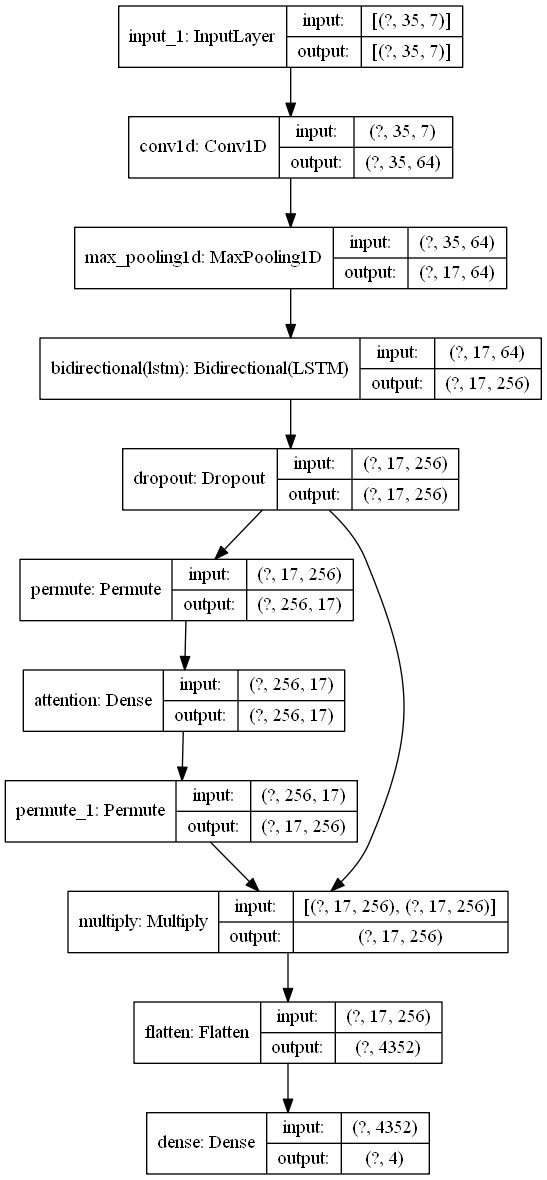

In [10]:
import pydotplus
import graphviz 
from keras.utils import plot_model
plot_model(model, to_file='.\\Vedio_tone.png', show_shapes=True)

In [356]:
from keras import optimizers
adam=optimizers.Adam(learning_rate=0.001)

In [357]:

model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
#plot_model(model,'model_tune.jpg',show_shapes=True)
save_model=kcallbacks.ModelCheckpoint(filepath=MODEL_SAVE_PATH,monitor='val_accuracy',verbose=1,save_best_only=True)
callback_list=[save_model]
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

Epoch 1/100
235/236 [============================>.] - ETA: 0s - loss: 1.2828 - accuracy: 0.3899
Epoch 00001: val_accuracy improved from -inf to 0.44846, saving model to .\models\gabor_tone_cnn1.h5
236/236 [==============================] - 7s 28ms/step - loss: 1.2826 - accuracy: 0.3898 - val_loss: 1.2414 - val_accuracy: 0.4485
Epoch 2/100
234/236 [============================>.] - ETA: 0s - loss: 1.2231 - accuracy: 0.4260
Epoch 00002: val_accuracy improved from 0.44846 to 0.45909, saving model to .\models\gabor_tone_cnn1.h5
236/236 [==============================] - 6s 25ms/step - loss: 1.2237 - accuracy: 0.4249 - val_loss: 1.2128 - val_accuracy: 0.4591
Epoch 3/100
236/236 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.4403
Epoch 00003: val_accuracy improved from 0.45909 to 0.47396, saving model to .\models\gabor_tone_cnn1.h5
236/236 [==============================] - 6s 25ms/step - loss: 1.2055 - accuracy: 0.4403 - val_loss: 1.2000 - val_accuracy: 0.4740
Epoc

In [165]:
from sklearn.model_selection import GridSearchCV
model1 = scikit_learn.KerasClassifier(build_fn=attention_model, verbose=0)

In [166]:
batch_size = [8,128]
epochs = [10,80]

In [167]:
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model1, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X, Y)

NameError: name 'X' is not defined

In [ ]:
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

In [110]:

model = keras.Sequential(
    [
        keras.Input(shape=(35,7)),
        layers.Conv1D(64, kernel_size=1, activation="relu"),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.5),
        a=layers.Dense(128, activation="sigmoid"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ]
)

model.summary()

SyntaxError: invalid syntax (<ipython-input-110-766435e54d28>, line 8)

In [46]:
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=64)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
cnn_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    # Use 'same' padding so outputs have the same shape as inputs.
    padding='same')
# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = cnn_layer(query_embeddings)
# Value encoding of shape [batch_size, Tv, filters].
value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = tf.keras.layers.Attention()(
    [query_seq_encoding, value_seq_encoding])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35, 7)]      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 35, 64)       512         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 35, 64)       0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 35, 128)      66048       dropout_2[0][0]                  
_______________________________________________________________________________________

In [74]:
query_embeddings

<tf.Tensor 'embedding_2/embedding_lookup/Identity_1:0' shape=(None, None, 64) dtype=float32>

## plot_curve

In [359]:
from keras.models import load_model
model=load_model('.\models\gabor_tone_cnn1.h5')
history=model.fit(x=X_train,y=y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(X_test,y_test),
                  callbacks=callback_list)

Epoch 1/100
 77/236 [========>.....................] - ETA: 3s - loss: 0.8338 - accuracy: 0.6672

KeyboardInterrupt: 

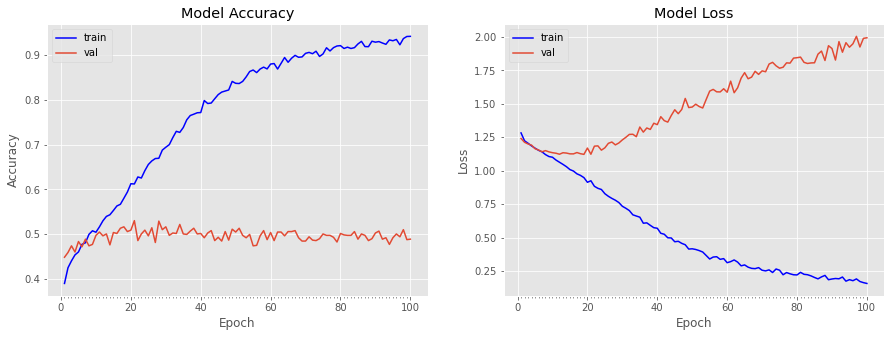

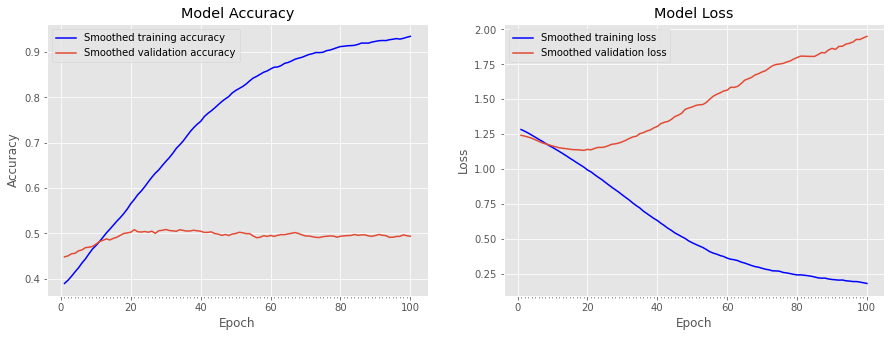

In [360]:
from help import plot_curve,plot_curve_with_smooth
plot_curve(history)
plot_curve_with_smooth(history)

## confusion_metrix

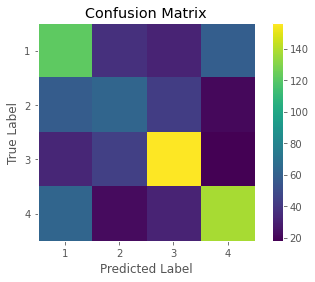

In [361]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred,axis=-1).ravel()
y_true=np.argmax(y_test,axis=-1).ravel()
con_matrix=confusion_matrix(y_true=y_true,y_pred=y_pred)
def plot_confusion_matrix(confusion_mat):
    plt.imshow(confusion_mat)
    plt.title('Confusion Matrix')
    plt.colorbar()
    labels = [1,2,3,4]
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.grid(False)
    plt.show() 
plot_confusion_matrix(con_matrix)

## classfication_report

In [362]:
from sklearn.metrics import classification_report


In [363]:
target_names = ['1', '2', '3','4']
print(classification_report(y_true,y_pred,digits=4,labels=[0,1,2,3],target_names=target_names))

              precision    recall  f1-score   support

           1     0.4420    0.4880    0.4639       250
           2     0.3795    0.3405    0.3590       185
           3     0.5932    0.6215    0.6070       251
           4     0.5847    0.5412    0.5621       255

    accuracy                         0.5090       941
   macro avg     0.4999    0.4978    0.4980       941
weighted avg     0.5087    0.5090    0.5081       941



# predict

In [20]:
import librosa
import sklearn
def get_mfcc_feature(path,maxlen=50):
    x, sr = librosa.load(path)
    # extract mfcc
    mfcc = librosa.feature.mfcc(x, sr=sr)
    # Center to the mean and component wise scale to unit variance
    mfcc = sklearn.preprocessing.scale(mfcc, axis=1)
    mfcc_diff = np.diff(mfcc, axis=0)
    mfcc_diff_diff = np.diff(mfcc_diff, axis=0)
    # concatenate mfcc,mfcc_diff and mfcc_diff_diff
    mfccs = np.concatenate([mfcc, mfcc_diff, mfcc_diff_diff], axis=0).T
    #pad the mfccs_feature
    if mfccs.shape[0]<maxlen:
        mfccs=np.concatenate([mfccs,np.zeros((maxlen-mfccs.shape[0],57))],axis=0)
    return mfccs

In [21]:
wav_file='./voice_data/person10_time1_group1_ba_1.wav'

In [22]:
test=get_mfcc_feature(path=wav_file)
test=np.expand_dims(test,axis=0)
pred=model.predict(test)
pred=np.argmax(pred,axis=1)[0]
print('Predict Label:%s'%(CLASSES_LIST[pred]))

Predict Label:1


In [38]:
temp = np.load('./gabor/person1_time1_group1_ba_1.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)
pred=np.argmax(pred,axis=1)[0]
print('Predict Label:%s'%(CLASSES_LIST[pred]))

(1, 35, 7)
Predict Label:1


In [40]:
temp = np.load('./gabor/person2_time1_group1_da_4.npy')
m,n = temp.shape
            #print(m)
if m <=35:
    left = 36 - m
    temp =np.append(temp,(np.zeros([left,n])),axis=0)
test =[]
test.append(temp[:35,])
test = np.array(test)
print(test.shape)
pred=model.predict(test)
pred=np.argmax(pred,axis=1)[0]
print('Predict Label:%s'%(CLASSES_LIST[pred]))

(1, 35, 7)
Predict Label:4


In [63]:
# Variable-length int sequences.
query_input = tf.keras.Input(shape=(None,), dtype='int32')
value_input = tf.keras.Input(shape=(None,), dtype='int32')

# Embedding lookup.
token_embedding = tf.keras.layers.Embedding(input_dim=1000, output_dim=64)
# Query embeddings of shape [batch_size, Tq, dimension].
query_embeddings = token_embedding(query_input)
# Value embeddings of shape [batch_size, Tv, dimension].
value_embeddings = token_embedding(value_input)

# CNN layer.
cnn_layer = tf.keras.layers.Conv1D(
    filters=100,
    kernel_size=4,
    # Use 'same' padding so outputs have the same shape as inputs.
    padding='same')
# Query encoding of shape [batch_size, Tq, filters].
query_seq_encoding = cnn_layer(query_embeddings)
# Value encoding of shape [batch_size, Tv, filters].
value_seq_encoding = cnn_layer(value_embeddings)

# Query-value attention of shape [batch_size, Tq, filters].
query_value_attention_seq = tf.keras.layers.Attention()(
    [query_seq_encoding, value_seq_encoding])

# Reduce over the sequence axis to produce encodings of shape
# [batch_size, filters].
query_encoding = tf.keras.layers.GlobalAveragePooling1D()(
    query_seq_encoding)
query_value_attention = tf.keras.layers.GlobalAveragePooling1D()(
    query_value_attention_seq)

# Concatenate query and document encodings to produce a DNN input layer.
input_layer = tf.keras.layers.Concatenate()(
    [query_encoding, query_value_attention])